### data and package imports

In [403]:
import os
from datetime import datetime

import umap
import imageio
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib import transforms
from matplotlib.patches import Patch
import statsmodels.api as sm
import statsmodels.formula.api as smf
from jenkspy import JenksNaturalBreaks
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# social determinants of health
sdoh_df = pd.read_excel("./data/SDOH_2020_COUNTY_1_0.xlsx", sheet_name="Data")

# unemployment rate dataset
unemp_df = pd.read_excel(
    "./data/Unemployment.xlsx",
    sheet_name="UnemploymentMedianIncome",
    skiprows=[0, 1, 2, 3],
    header=None,
)
unemp_df = pd.DataFrame(unemp_df.values[1:], columns=unemp_df.iloc[0])

# poverty rate dataset
pov_df = pd.read_excel(
    "./data/PovertyEstimates.xlsx",
    sheet_name="PovertyEstimates",
    skiprows=[0, 1, 2, 3],
    header=None,
)
pov_df = pd.DataFrame(pov_df.values[1:], columns=pov_df.iloc[0])

# geometry shape file - county level
cgdf = gpd.read_file("./data/cb_2022_us_county_500k/cb_2022_us_county_500k.shp")

# geometry shape file - state level
sgdf = gpd.read_file("./data/cb_2022_us_state_500k/cb_2022_us_state_500k.shp")
sgdf = sgdf.drop(['ALAND', 'AWATER','GEOID', 'AFFGEOID', 'STATENS'], axis=1)

# opioid overdose death
death_df = pd.read_csv("./data/Multiple Cause of Death, 2018-2021, Single Race (2).txt", sep="\t")
death_df = death_df.drop(columns="Notes").dropna()

In [381]:
# Opioid dispensing rate 2006-2020
# set to True if we want to refresh CDC data source
REFRESH_OPIOID_SOURCE = False

if REFRESH_OPIOID_SOURCE:
    for i in range(2006, 2021):
        print(f"at: {i}")
        df = pd.read_html(
            f"https://www.cdc.gov/drugoverdose/rxrate-maps/county{i}.html"
        )[0]
        df["year"] = i
        df.to_csv(f"./data/opioid_rx/{i}.csv")

l = [
    pd.read_csv(f"./data/opioid_rx/{file}")
    for file in os.listdir("./data/opioid_rx")
    if file[-3:] == "csv"
]
df = pd.concat(l)

df["year"] = df["year"].fillna(2020)
df["Opioid Dispensing Rate per 100"] = (
    df["Opioid Dispensing Rate per 100"].replace("–", np.nan).astype("float32")
)
df["County FIPS Code"] = np.where(
    (df["year"] == 2020), df["State_County FIPS Code"], df["County FIPS Code"]
)

df = df.reset_index().drop(
    ["Unnamed: 0", "index", "State_County FIPS Code", "State FIPS code"], axis=1
)
df.sample(5)

,County,State,County FIPS Code,Opioid Dispensing Rate per 100,year
2147,"Cotton, OK",OK,40033.0,NaN,2008.0
46447,"Dane, WI",WI,55025.0,68.900002,2011.0
46031,"Eastland, TX",TX,48133.0,76.699997,2011.0
22748,"Bienville, LA",LA,22013.0,59.400002,2016.0
27902,"Graham, AZ",AZ,4009.0,117.000000,2013.0


In [ ]:
# try umap
sdoh_umap = sdoh_df.copy().iloc[:, 8:].fillna(0)

# use standardscaler 
ss = StandardScaler()

for i in range(5, 15):
     # UMAP: n_neighbors must >= 5
     print(f"testing n_neighbors = {i}")
     trans = umap.UMAP(n_neighbors=i, n_jobs=-1).fit(sdoh_umap)
     plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1])
     plt.savefig(f"./viz_raw/umap/{i}.png", dpi=72)

### Exploratory data analysis - opioid dispensing rate

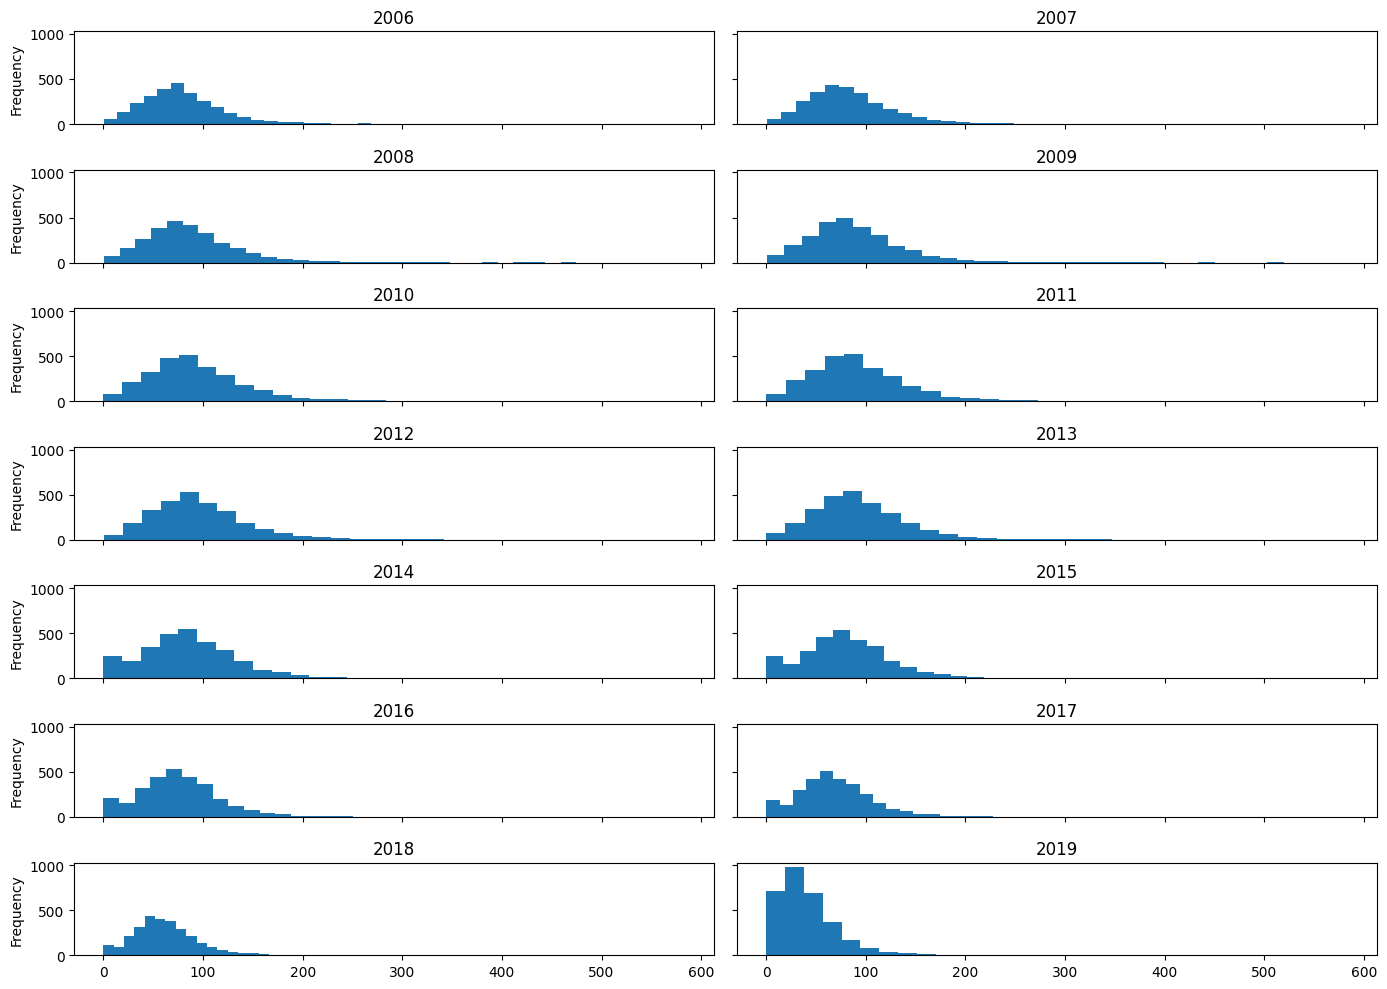

In [7]:
(
    df[["Opioid Dispensing Rate per 100", "year"]].plot.hist(
        by="year",
        figsize=(14, 10),
        layout=(7, 2),
        sharex=True,
        sharey=True,
        legend=False,
        bins=30,
    )
)

plt.tight_layout()

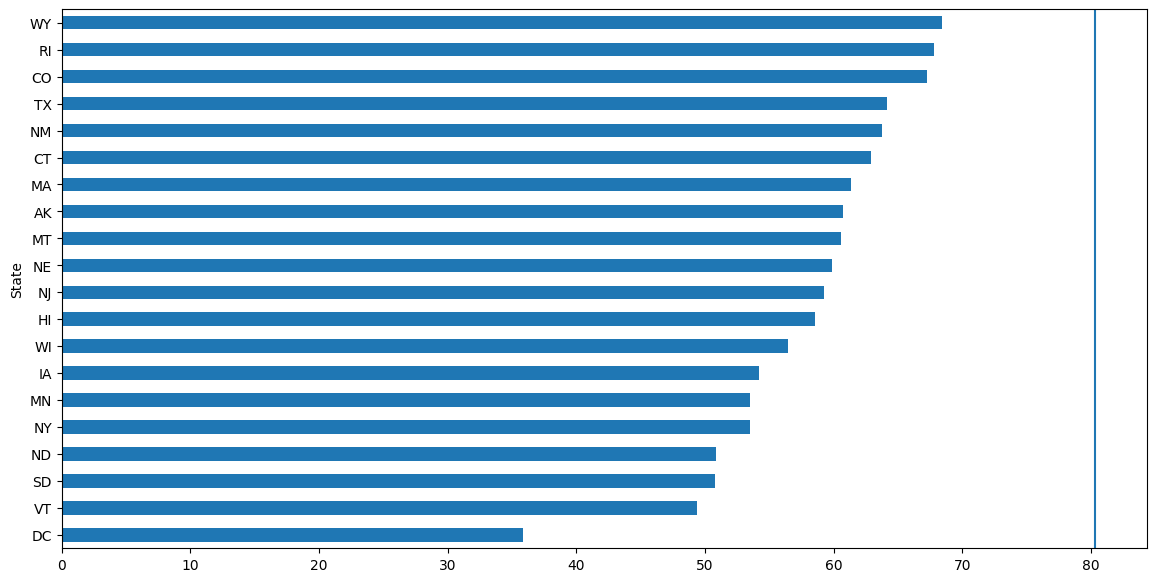

In [8]:
plt.figure(figsize=(14, 7))

(
    df
    .groupby("State")["Opioid Dispensing Rate per 100"]
    .mean()
    .sort_values()
    .head(20)
    .plot.barh()
)

plt.axvline(x=df['Opioid Dispensing Rate per 100'].mean())

Text(0.5, 1.0, 'Opioid dispensing rate per 100 (2006-2019)')

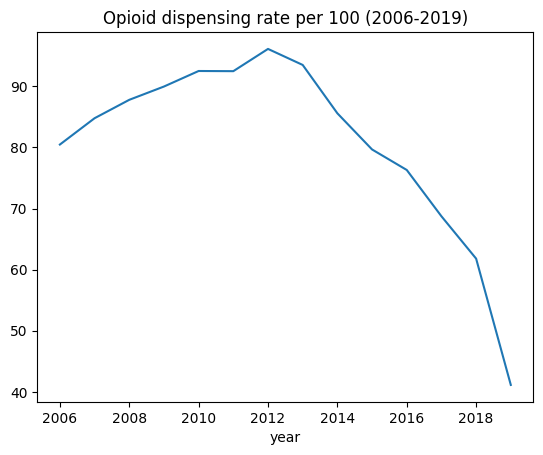

In [9]:
(
    df
    .groupby("year")["Opioid Dispensing Rate per 100"]
    .mean()
    .plot.line()
)

plt.title("Opioid dispensing rate per 100 (2006-2019)")

In [398]:
trydf = df.copy()
trydf = trydf.rename(columns={"County FIPS Code": "GEOID"})
trydf['GEOID'] = trydf['GEOID'].astype("float")
cgdf['GEOID'] = cgdf['GEOID'].astype("float")
# cgdf["GEOID"] = cgdf["GEOID"].str.lstrip("0")
trydf["year"] = trydf["year"].astype("int")

In [399]:
gdf = cgdf.merge(trydf, how="left", on="GEOID").drop(
    columns=[
        "STATEFP",
        "COUNTYFP",
        "COUNTYNS",
        "AFFGEOID",
        "LSAD",
        "ALAND",
        "AWATER",
    ]
)

In [ ]:
# https://stackoverflow.com/questions/67575936/moving-alaska-and-hawaii-in-geopandas-for-choropleths
vmin = gdf["Opioid Dispensing Rate per 100"].min()
vmax = gdf["Opioid Dispensing Rate per 100"].max()

plot_extra = True
for i in tqdm(range(2006, 2021)):
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))

    gdf[~(gdf["State"].isin(["AK", "HI"])) & (gdf["year"] == i)].to_crs(
        epsg=2163
    ).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        legend=True,
        ax=ax,
        legend_kwds={"label": "Opioid Dispensing Rate per 100", "shrink": 0.7},
        edgecolor="k",
        vmin=vmin,
        vmax=vmax
    )
    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"Opioid dispensing rate per 100 persons, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.3])
    gdf[(gdf["State"] == "AK") & (gdf["year"] == i)].to_crs(epsg=3338).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        ax=ax_ak,
        vmin=vmin,
        vmax=vmax,
        edgecolor="k",
    )
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    ax_hi = fig.add_axes([0.43, 0.05, 0.2, 0.3])
    gdf[(gdf["State"] == "HI") & (gdf["year"] == i)].to_crs(epsg=4326).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        ax=ax_hi,
        vmin=vmin,
        vmax=vmax,
        edgecolor="k",
    )
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        #
        ax_pp = fig.add_axes([1, 0.58, 0.3, 0.27])
        mean_df = (
            gdf.groupby("year")["Opioid Dispensing Rate per 100"].mean().reset_index()
        )
        ax_pp.plot_date(
            pd.to_datetime(i, format="%Y"),
            [mean_df.loc[i - 2006]["Opioid Dispensing Rate per 100"]],
            "go",
        )
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        mean_df[["year", "Opioid Dispensing Rate per 100"]].plot(
            x="year", y="Opioid Dispensing Rate per 100", ax=ax_pp
        )
        ax_pp.set_title("Yearly trend of national mean dispensing rate")
        ax_pp.set_ylabel("Dispensing rate per 100 persons")
        ax_pp.annotate(
            f"{i} Mean: {str(round(mean_df.loc[i-2006]['Opioid Dispensing Rate per 100'], 1))}",
            xy=(pd.to_datetime(2007, format="%Y"), 45),
        )
        ax_pp.get_legend().remove()

        # histogram of dispensing rate of year
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        gdf[gdf["year"] == i]["Opioid Dispensing Rate per 100"].plot(
            kind="hist", ax=ax_hist, bins=30
        )
        ax_hist.set_title(f"Distribution of dispensing rate for {i}")
        ax_hist.set_xlim(vmin, vmax)

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"./viz_raw/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

In [406]:
fname = "./visualization/2006-2020 county continuous opioid dispensing rate.gif"

with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in tqdm(sorted([f for f in os.listdir(os.curdir + "/viz_raw") if os.path.isfile(os.curdir + "/viz_raw/" + f)])):
        image = imageio.imread("./viz_raw/" + filename)
        writer.append_data(image)

  0%|          | 0/15 [00:00<?, ?it/s]

### Exploratory data analysis - unemployment rate

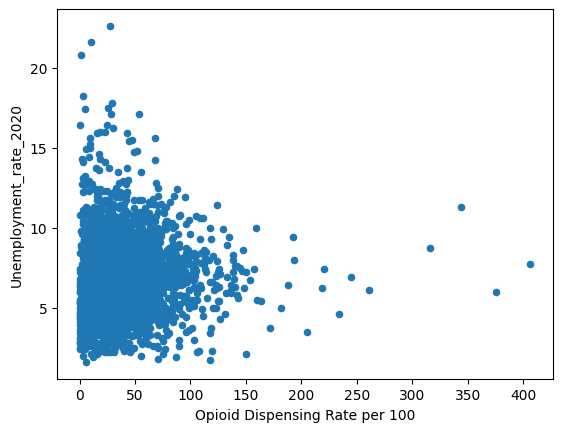

In [423]:
y = 2020

df_sub = df.query(f"year == {y}")
df_sub['County FIPS Code'] = df_sub['County FIPS Code'].astype("int").astype("str")
df_sub['County FIPS Code'] = df_sub['County FIPS Code'].str.pad(5, side = "left", fillchar='0')

unemp_dispense = (
    df_sub.merge(
        unemp_df.loc[:, unemp_df.columns.str.contains(f"FIPS|Unemployment_rate_{y}")],
        how="left",
        right_on = "FIPS_Code",
        left_on = "County FIPS Code"
    )
)

unemp_dispense.plot(x = "Opioid Dispensing Rate per 100", y = f"Unemployment_rate_{y}", kind = 'scatter');

In [424]:
unemp_dispense[f'Unemployment_rate_{y}'] = unemp_dispense[f'Unemployment_rate_{y}'].astype("float")
s = smf.ols(formula = f"Q('Opioid Dispensing Rate per 100') ~ Q('Unemployment_rate_{y}')", data=unemp_dispense).fit()
s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                    
===============================================================================================
Dep. Variable:     Q('Opioid Dispensing Rate per 100')   R-squared:                       0.003
Model:                                             OLS   Adj. R-squared:                  0.003
Method:                                  Least Squares   F-statistic:                     10.20
Date:                                 Tue, 31 Oct 2023   Prob (F-statistic):            0.00142
Time:                                         10:42:26   Log-Likelihood:                -14938.
No. Observations:                                 3081   AIC:                         2.988e+04
Df Residuals:                                     3079   BIC:                         2.989e+04
Df Model:                                            1                                         
Covariance Type:                             nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      33.5290      1.733     19.346      0.000      30.131      36.927
Q('Unemployment_rate_2020')     0.7704      0.241      3.193      0.001       0.297       1.243
==============================================================================
Omnibus:                     2116.103   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            55004.842
Skew:                           2.898   Prob(JB):                         0.00
Kurtosis:                      22.871   Cond. No.                         22.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [409]:
# counties with highest dispensing rate
mi = df.groupby('year')['Opioid Dispensing Rate per 100'].idxmax() 

df.reset_index().loc[mi]

,index,County,State,County FIPS Code,Opioid Dispensing Rate per 100,year
36936,36936,"Martinsville, VA",VA,51690.0,403.299988,2006.0
33793,33793,"Martinsville, VA",VA,51690.0,438.399994,2007.0
2923,2923,"Martinsville, VA",VA,51690.0,474.700012,2008.0
9147,9147,"Martinsville, VA",VA,51690.0,520.099976,2009.0
43222,43222,"Martinsville, VA",VA,51690.0,566.400024,2010.0
46365,46365,"Martinsville, VA",VA,51690.0,583.799988,2011.0
40082,40082,"Norton, VA",VA,51720.0,570.099976,2012.0
30653,30653,"Norton, VA",VA,51720.0,578.099976,2013.0
21412,21412,"Norton, VA",VA,51720.0,563.299988,2014.0
18269,18269,"Norton, VA",VA,51720.0,504.899994,2015.0


### State level dispensing rate

In [352]:
state_rx = df.groupby(['State', 'year'], as_index=False).agg({"Opioid Dispensing Rate per 100": "mean"})

jnb = JenksNaturalBreaks(5)
jnb.fit(state_rx['Opioid Dispensing Rate per 100'])

cls = []
for i in range(len(jnb.breaks_)):
     try: 
          a = str(round(jnb.breaks_[i], 1))
          b = str(round(jnb.breaks_[i+1], 1))
          cls.append(f"{a}-{b}")
     except:
          pass

state_rx['cls'] = state_rx['Opioid Dispensing Rate per 100'].apply(lambda x: "abcde"[jnb.predict(x)])

In [412]:
state_rx.loc[state_rx.groupby(['year'])['Opioid Dispensing Rate per 100'].idxmax()]

,State,year,Opioid Dispensing Rate per 100,cls
630,TN,2006.0,126.802170,e
631,TN,2007.0,134.281311,e
632,TN,2008.0,138.218277,e
633,TN,2009.0,146.366669,e
634,TN,2010.0,152.250534,e
635,TN,2011.0,150.708603,e
636,TN,2012.0,150.129028,e
637,TN,2013.0,145.515228,e
638,TN,2014.0,136.963165,e
639,TN,2015.0,129.495789,e


In [353]:
strx_gdf = sgdf[['STUSPS', 'geometry']].merge(state_rx, how="right", left_on="STUSPS", right_on="State")
strx_gdf.head(5)

,STUSPS,geometry,State,year,Opioid Dispensing Rate per 100,cls
0,AK,"MULTIPOLYGON (((-152.85279 70.89539, -152.8498...",AK,2006.0,84.533333,c
1,AK,"MULTIPOLYGON (((-152.85279 70.89539, -152.8498...",AK,2007.0,80.070000,c
2,AK,"MULTIPOLYGON (((-152.85279 70.89539, -152.8498...",AK,2008.0,82.590004,c
3,AK,"MULTIPOLYGON (((-152.85279 70.89539, -152.8498...",AK,2009.0,82.650002,c
4,AK,"MULTIPOLYGON (((-152.85279 70.89539, -152.8498...",AK,2010.0,84.270004,c


In [ ]:
# https://stackoverflow.com/questions/67575936/moving-alaska-and-hawaii-in-geopandas-for-choropleths
vmin = strx_gdf["Opioid Dispensing Rate per 100"].min()
vmax = strx_gdf["Opioid Dispensing Rate per 100"].max()

plot_extra = True
for i in range(2006, 2021):
    print(f"making {i} plot")
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))

    
    strx_gdf[~(strx_gdf["State"].isin(["AK", "HI"])) & (strx_gdf["year"] == i)].to_crs(
        epsg=2163
    ).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        legend=True,
        ax=ax,
        legend_kwds={"label": "Opioid Dispensing Rate per 100", "shrink": 0.7},
        edgecolor="k",
        vmin=vmin,
        vmax=vmax
    )
    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"Opioid dispensing rate per 100 persons, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.3])
    strx_gdf[(strx_gdf["State"] == "AK") & (strx_gdf["year"] == i)].to_crs(epsg=3338).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        ax=ax_ak,
        vmin=vmin,
        vmax=vmax,
        edgecolor="k",
    )
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    ax_hi = fig.add_axes([0.43, 0.05, 0.2, 0.3])
    strx_gdf[(strx_gdf["State"] == "HI") & (strx_gdf["year"] == i)].to_crs(epsg=4326).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        ax=ax_hi,
        vmin=vmin,
        vmax=vmax,
        edgecolor="k",
    )
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        #
        ax_pp = fig.add_axes([1, 0.58, 0.3, 0.27])
        mean_df = (
            strx_gdf.groupby("year")["Opioid Dispensing Rate per 100"].mean().reset_index()
        )
        ax_pp.plot_date(
            pd.to_datetime(i, format="%Y"),
            [mean_df.loc[i - 2006]["Opioid Dispensing Rate per 100"]],
            "go",
        )
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        mean_df[["year", "Opioid Dispensing Rate per 100"]].plot(
            x="year", y="Opioid Dispensing Rate per 100", ax=ax_pp
        )
        ax_pp.set_title("Yearly trend of national mean dispensing rate")
        ax_pp.set_ylabel("Dispensing rate per 100 persons")
        ax_pp.annotate(
            f"{i} Mean: {str(round(mean_df.loc[i-2006]['Opioid Dispensing Rate per 100'], 1))}",
            xy=(pd.to_datetime(2007, format="%Y"), 45),
        )
        ax_pp.get_legend().remove()

        # histogram of dispensing rate of year
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        strx_gdf[strx_gdf["year"] == i]["Opioid Dispensing Rate per 100"].plot(
            kind="hist", ax=ax_hist, bins=15
        )
        ax_hist.set_title(f"Distribution of dispensing rate for {i}")
        ax_hist.set_xlim(vmin, vmax)

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"./viz_raw/state/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

fname = "./visualization/2006-2020 state continuous opioid dispensing rate.gif"

with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in sorted([f for f in os.listdir(os.curdir + "/viz_raw/state/") if os.path.isfile(os.curdir + "/viz_raw/state/" + f)]):
        image = imageio.imread("./viz_raw/state/" + filename)
        writer.append_data(image)

In [ ]:
# https://stackoverflow.com/questions/67575936/moving-alaska-and-hawaii-in-geopandas-for-choropleths
vmin = strx_gdf["Opioid Dispensing Rate per 100"].min()
vmax = strx_gdf["Opioid Dispensing Rate per 100"].max()

colmap = plt.cm.Reds

plot_color = [mcolors.to_hex(c) for c in colmap([0.2, 0.4, 0.6, 0.8, 1.0])]
color_dict = {i:c for i,c in zip("abcde", plot_color)}

plot_extra = True
for i in range(2006, 2021):
    print(f"making {i} plot")
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))

    filtered_data = filtered_data = strx_gdf[~(strx_gdf["State"].isin(["AK", "HI"])) & (strx_gdf["year"] == i)].to_crs(epsg=2163)
    filtered_data.plot(
        # column="Opioid Dispensing Rate per 100",
        # scheme="user_defined",
        # classification_kwds=dict(bins=jnb.breaks_),
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        legend=True,
        ax=ax,
        legend_kwds={"frameon": False, "labels": cls, 'loc':'lower right'},
        edgecolor="k",
    )

    legend_patches = [Patch(color=color_dict[cls], label=cls) for cls in color_dict.keys()]
    ax.legend(handles=legend_patches, frameon=False, loc='lower right', labels=cls)

    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"Opioid dispensing rate per 100 persons, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.2])
    strx_gdf[(strx_gdf["State"] == "AK") & (strx_gdf["year"] == i)].to_crs(
        epsg=3338
    ).fillna(1e-6).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        ax=ax_ak,
        edgecolor="k",
    )
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    ax_hi = fig.add_axes([0.59, 0.05, 0.2, 0.2])
    strx_gdf[(strx_gdf["State"] == "HI") & (strx_gdf["year"] == i)].to_crs(
        epsg=4326
    ).fillna(1e-6).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        ax=ax_hi,
        edgecolor="k",
    )
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        #
        ax_pp = fig.add_axes([1, 0.58, 0.3, 0.27])
        mean_df = (
            strx_gdf.groupby("year")["Opioid Dispensing Rate per 100"]
            .mean()
            .reset_index()
        )
        ax_pp.plot_date(
            pd.to_datetime(i, format="%Y"),
            [mean_df.loc[i - 2006]["Opioid Dispensing Rate per 100"]],
            "go",
        )
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        mean_df[["year", "Opioid Dispensing Rate per 100"]].plot(
            x="year", y="Opioid Dispensing Rate per 100", ax=ax_pp
        )
        ax_pp.set_title("Yearly trend of national mean dispensing rate")
        ax_pp.set_ylabel("Dispensing rate per 100 persons")
        ax_pp.annotate(
            f"{i} Mean: {str(round(mean_df.loc[i-2006]['Opioid Dispensing Rate per 100'], 1))}",
            xy=(pd.to_datetime(2007, format="%Y"), 45),
        )
        ax_pp.get_legend().remove()

        # histogram of dispensing rate of year
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        strx_gdf[strx_gdf["year"] == i]["Opioid Dispensing Rate per 100"].plot(
            kind="hist", ax=ax_hist, bins=15
        )
        ax_hist.set_title(f"Distribution of dispensing rate for {i}")
        ax_hist.set_xlim(vmin, vmax)

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"./viz_raw/state_jnb/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

fname = "./visualization/2006-2020 state opioid dispensing rate.gif"

with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in sorted([f for f in os.listdir(os.curdir + "/viz_raw") if os.path.isfile(os.curdir + "/viz_raw/" + f)]):
        image = imageio.imread("./viz_raw/" + filename)
        writer.append_data(image)

### Exploratory data analysis - opioid death rates

In [427]:
# if we also want to consider the unreliable data points
death_df['Rate'] = (death_df['Deaths'] / death_df['Population']) * 100000
death_df

,County,County Code,Deaths,Population,Crude Rate,Rate
0,"Baldwin County, AL",1003.0,153.0,909837.0,16.8,16.816199
1,"Bibb County, AL",1007.0,10.0,89407.0,Unreliable,11.184807
2,"Blount County, AL",1009.0,24.0,232586.0,10.3,10.318764
3,"Calhoun County, AL",1015.0,41.0,457323.0,9.0,8.965217
4,"Chilton County, AL",1021.0,24.0,178252.0,13.5,13.464085
...,...,...,...,...,...,...
2041,"Fremont County, WY",56013.0,39.0,157445.0,24.8,24.770555
2042,"Laramie County, WY",56021.0,48.0,399934.0,12.0,12.001980
2043,"Natrona County, WY",56025.0,34.0,319343.0,10.6,10.646859
2044,"Niobrara County, WY",56027.0,0.0,9457.0,Unreliable,0.000000


In [ ]:
death_df.merge(state_rx, how="left", )

### DO NOT USE

In [310]:
import matplotlib.pyplot as plt
import matplotlib
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom  #for box drawing
import geopandas as gpd
import numpy as np
import mapclassify as mc
import pandas as pd

my_colormap = matplotlib.cm.Reds
edgecolor = "black"

In [ ]:
newusa = gdf.copy()
col = "Opioid Dispensing Rate per 100"


# A function that draws inset map
def add_insetmap(axes_extent, map_extent, state_name, facecolor, edgecolor, geometry):
    # create new axes, set its projection
    use_projection = ccrs.Mercator()  # preserves shape
    geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum="WGS84"))
    sub_ax = plt.axes(axes_extent, projection=use_projection)  # normal units
    sub_ax.set_extent(map_extent, geodetic)  # map extents

    # option to add basic land, coastlines of the map
    # can comment out if you don't need them
    sub_ax.add_feature(cartopy.feature.LAND)
    sub_ax.coastlines()
    sub_ax.set_title(state_name)

    # add map `geometry`
    sub_ax.add_geometries(
        [geometry], ccrs.Mercator(), facecolor=facecolor, edgecolor=edgecolor, lw=0.4,
    )

    # plot box around the map
    extent_box = sgeom.box(map_extent[0], map_extent[2], map_extent[1], map_extent[3])
    sub_ax.add_geometries([extent_box], ccrs.PlateCarree(), color="none")


# excluding non-conterminous states
usa_main = newusa[~newusa["State"].isin(["AK", "HI"])]
usa_main.crs = {"init": "epsg:4326"}
usa_main = usa_main.to_crs(epsg=2163)

# non-conterminous states, namely, Alaska and Hawaii
usa_more = newusa[newusa["State"].isin(["AK", "HI"])]  # include these
usa_more.crs = {"init": "epsg:4326"}
usa_more = usa_more.to_crs(epsg=2163)

# plot 1st part, using usa_main and grab its axis as 'ax2'
ax2 = usa_main.plot(
    column=col, legend=False, cmap=matplotlib.cm.Reds, ec=edgecolor, lw=0.4
)

# manipulate colorbar/legend
fig = ax2.get_figure()
cax = fig.add_axes([0.9, 0.25, 0.02, 0.5])  # [left,bottom,width,height]
sm = plt.cm.ScalarMappable(
    cmap=my_colormap, norm=plt.Normalize(vmin=min(newusa[col]), vmax=max(newusa[col]))
)

# # clear the array of the scalar mappable
sm._A = []
cb = fig.colorbar(sm, cax=cax)

cb.set_label("Opioid dispensing rate 2019")
ax2.set_frame_on(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_title("Opioid dispensing rate 2019")

# plot Alaska, Hawaii as inset maps
for index, state in usa_more.dissolve(by='State').iterrows():
    st_name = index
    facecolor = my_colormap(state[col] / max(newusa[col]))
    if st_name == "AK":
        map_extent = (-180, -125, 46, 73)
        axes_extent = (0.04, 0.06, 0.29, 0.275)
    elif st_name == "HI":
        map_extent = (-162, -152, 15, 25)
        axes_extent = (0.27, 0.06, 0.15, 0.15)
    add_insetmap(
        axes_extent, map_extent, st_name, facecolor, edgecolor, state["geometry"]
    )
plt.show()

In [479]:
import sys
sys.modules[__name__].__dict__.clear()

# References

1. https://stackoverflow.com/questions/55767312/how-to-position-suptitle
2. https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size
3. https://geopandas.org/en/stable/docs/user_guide/missing_empty.html
4. 